# packages

In [1]:
import os
from random import randint
import uuid

from quinine import QuinineArgumentParser
from tqdm import tqdm
import torch
import yaml

from tasks import get_task_sampler, mse_loss
from samplers import get_data_sampler
from curriculum import Curriculum
from schema import schema
from models import build_model, build_GD_model
from tasks import pl_loss_single
import wandb
import matplotlib.pyplot as plt
import numpy as np
from quinine import Quinfig
torch.backends.cudnn.benchmark = True

# utils

In [2]:
def eval_step(model, xs, ini_ys, ys, rs, loss_func):
    output = model(xs, ys, rs)
    loss = loss_func(output, ys, rs, ini_ys)
    return loss.detach().item(), output.detach()


def sample_seeds(total_seeds, count):
    seeds = set()
    while len(seeds) < count:
        seeds.add(randint(0, total_seeds - 1))
    return seeds

# evaluate

In [3]:
def random_replace(rs1, p):
    rs_cpy = rs1.clone()
    random_values = torch.rand_like(rs_cpy)
    mask = torch.rand_like(rs_cpy) < p
    rs_cpy[mask] = random_values[mask]
    return rs_cpy.cuda()


def evaluate(model, args):
    curriculum = Curriculum(args.training.curriculum)
    n_dims = model.n_dims
    bsize = args.training.batch_size
    data_sampler = get_data_sampler(args.training.data, n_dims=n_dims)
    task_sampler = get_task_sampler(
        args.training.task,
        n_dims,
        bsize,
        **args.training.task_kwargs,
    )


    data_sampler_args = {}
    task_sampler_args = {}


    xs, epsilons, rs = data_sampler.sample_xs(
        curriculum.n_points,
        bsize,
        curriculum.n_dims_truncated,
        **data_sampler_args,
    )

    random_r = {}

    for p in [0, 0.25 ,0.5, 0.75, 1 ]:
        random_r[str(p)] = random_replace(rs,p)

    
    task = task_sampler(**task_sampler_args)
    ini_ys, ys = task.evaluate(xs, epsilons, rs) # save ys for eval
    
    loss_func = task.get_training_metric()

    _, output_0 = eval_step(model, xs.cuda(), ini_ys.cuda(), ys.cuda(), random_r[str(0)].cuda(), loss_func)
    _, output_25 = eval_step(model, xs.cuda(), ini_ys.cuda(), ys.cuda(), random_r[str(0.25)].cuda(), loss_func)
    _, output_50 = eval_step(model, xs.cuda(), ini_ys.cuda(), ys.cuda(), random_r[str(0.5)].cuda(), loss_func)
    _, output_75 = eval_step(model, xs.cuda(), ini_ys.cuda(), ys.cuda(), random_r[str(0.75)].cuda(), loss_func)
    _, output_100 = eval_step(model, xs.cuda(), ini_ys.cuda(), ys.cuda(), random_r[str(1)].cuda(), loss_func)

    eval_losses_0 = 1 - torch.cosine_similarity(output_0.cuda(), ini_ys.cuda(), dim=2).mean(dim=0).detach().cpu().numpy()
    eval_losses_25 = 1 - torch.cosine_similarity(output_25.cuda(), ini_ys.cuda(), dim=2).mean(dim=0).detach().cpu().numpy()
    eval_losses_50 = 1 - torch.cosine_similarity(output_50.cuda(), ini_ys.cuda(), dim=2).mean(dim=0).detach().cpu().numpy()
    eval_losses_75 = 1 - torch.cosine_similarity(output_75.cuda(), ini_ys.cuda(), dim=2).mean(dim=0).detach().cpu().numpy()
    eval_losses_100 = 1 - torch.cosine_similarity(output_100.cuda(), ini_ys.cuda(), dim=2).mean(dim=0).detach().cpu().numpy()

    b, num, dim = ys.size()

    GD = {}
    for p in [0, 0.25 ,0.5, 0.75, 1 ]:
        GD_eval_sum = np.zeros(num)
        for batch in tqdm(range(b)):
            y_tmp = ys[batch]
            r_tmp = random_r[str(p)][batch]
            GD_eval = np.zeros(num)
            for i in range(num):
                
                if i>0:
                    model_GD = build_GD_model(args.model).cuda().train()
                    tmp_optimizer = torch.optim.Adam(model_GD.parameters(), lr=0.1)
                    n=int(50 - p*25)
                    for step in range(n):
                        tmp_optimizer.zero_grad()
                        GD_output = model_GD(xs[batch][0].cuda())
                        current_ys = y_tmp[:i+1]
                        current_rs = r_tmp[:i+1]
                        tmploss = pl_loss_single(GD_output.cuda(), current_ys.cuda(), current_rs.cuda())
                        tmploss.backward()
                        tmp_optimizer.step()


                    GD_output_new = model_GD(xs[batch][0].cuda())
                    cos_loss = torch.cosine_similarity(GD_output_new.squeeze().cuda(), ini_ys[batch].cuda()).detach()
                    GD_eval[i] = 1 - cos_loss[0]
                else:
                    GD_eval[0] = 0
            GD_eval_sum += GD_eval
            
        GD_eval_avg = GD_eval_sum / (b)
        # print(GD_eval_avg[1:15])
        GD[str(p)] = GD_eval_avg
    



    

    return eval_losses_0[2:16], eval_losses_25[2:16], eval_losses_50[2:16], eval_losses_75[2:16], eval_losses_100[2:16], GD





# Main

In [4]:

args_20 = Quinfig(config_path='../models/alignment-n_layer-20/FFN_True_Softmax_True/config.yaml')

model_20= build_model(args_20.model)
state_dict_20 = torch.load("../models/alignment-n_layer-20/FFN_True_Softmax_True/state.pt")
model_20.load_state_dict(state_dict_20["model_state_dict"])
model_20.cuda()
model_20.eval()
eval_losses_0, eval_losses_25 ,eval_losses_50, eval_losses_75, eval_losses_100, GD = evaluate(model_20, args_20)

print(eval_losses_0, eval_losses_25 ,eval_losses_50, eval_losses_75, eval_losses_100)



100%|██████████| 256/256 [03:05<00:00,  1.38it/s]

[0.5190777  0.37028313 0.34688032 0.33575922 0.32744074 0.3184749
 0.3145303  0.30946165 0.3067454  0.30448288 0.3020534  0.30107903
 0.29800475 0.29655862] [0.646998   0.5124547  0.505033   0.47651196 0.46034968 0.4491818
 0.43977582 0.4267131  0.42151725 0.41799277 0.4101709  0.40671504
 0.40120566 0.3988272 ] [0.7809036  0.6938913  0.6794183  0.6650605  0.6664566  0.6430673
 0.61568576 0.6177335  0.62021786 0.61745316 0.617147   0.6211642
 0.6222148  0.6237248 ] [0.9237626  0.8667624  0.88775057 0.9215847  0.89721966 0.90822345
 0.8895166  0.8801285  0.8668726  0.8501115  0.84422356 0.8405421
 0.8321421  0.83749205] [1.0218837 1.0507113 1.0605636 1.0672938 1.0668027 1.0629807 1.079377
 1.0796951 1.0652155 1.0616719 1.0608491 1.0699285 1.078628  1.0834005]


# Draw figure

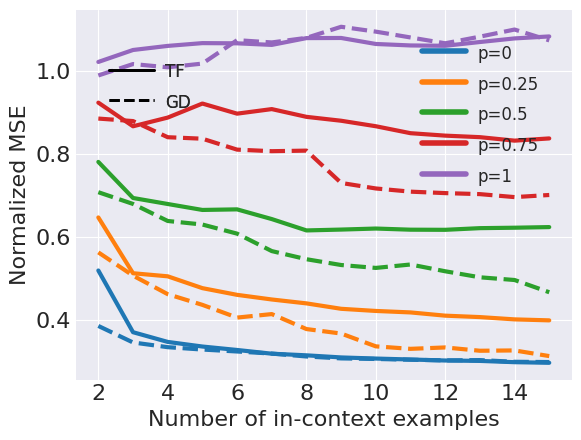

In [6]:
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

t_values = list(range(2, 16))

plt.style.use('seaborn-darkgrid')
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.gca().set_prop_cycle(cycler('color', default_colors))

plt.plot(t_values, eval_losses_0, label='p=0', linestyle='-')
plt.plot(t_values, eval_losses_25, label='p=0.25', linestyle='-')
plt.plot(t_values, eval_losses_50, label='p=0.5', linestyle='-')
plt.plot(t_values, eval_losses_75, label='p=0.75', linestyle='-')
plt.plot(t_values, eval_losses_100, label='p=1', linestyle='-')

plt.gca().set_prop_cycle(cycler('color', default_colors))

plt.plot(t_values, GD['0'][1:15], linestyle='--', label='GD p=0')
plt.plot(t_values, GD['0.25'][1:15], linestyle='--', label='GD p=0.25')
plt.plot(t_values, GD['0.5'][1:15], linestyle='--', label='GD p=0.5')
plt.plot(t_values, GD['0.75'][1:15], linestyle='--', label='GD p=0.75')
plt.plot(t_values, GD['1'][1:15], linestyle='--', label='GD p=1')

handles, labels = ax.get_legend_handles_labels()

color_legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in default_colors[:5]]
color_legend_labels = ['p=0', 'p=0.25', 'p=0.5', 'p=0.75', 'p=1']
color_legend = plt.legend(color_legend_handles, color_legend_labels,  loc='upper right',
                          handletextpad=0.5, borderpad=1, frameon=False, shadow=False)

line_legend_handles = [plt.Line2D([0], [0], color='k', lw=2, linestyle='-'),
                       plt.Line2D([0], [0], color='k', lw=2, linestyle='--')]
line_legend_labels = ['TF', 'GD']
line_legend = plt.legend(line_legend_handles, line_legend_labels, loc='upper left',
                         handletextpad=0.5, borderpad=1, frameon=False, shadow=False,bbox_to_anchor=(0, 0.95))

ax.add_artist(color_legend)
ax.add_artist(line_legend)

color_legend.get_frame().set_facecolor('white')
line_legend.get_frame().set_facecolor('white')
for legend in [color_legend, line_legend]:
    legend.get_frame().set_edgecolor('black') 
    for text in legend.get_texts():
        text.set_fontsize(12)  

plt.xlabel('Number of in-context examples')
plt.ylabel('Normalized MSE')

plt.savefig('wrong_reward.pdf')  

plt.show()
